# Set cover problem

Specifications of the problem : [https://en.wikipedia.org/wiki/Set_cover_problem](https://en.wikipedia.org/wiki/Set_cover_problem)

## Data

In [627]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import accumulate

UNIVERSE_SIZE = 10_000
NUM_SETS = 1_000
DENSITY = 0.2

## Intialization

In [628]:
SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

iterations = 3_000

### Helper Functions

In [629]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## First solution

At first, I just wanted to have a minimal working hill climber to upgrade it later.

As discussed in class, we can define the fitness of a solution with this function :

In [630]:
def fitness(solution: np.ndarray) -> tuple[bool, int]:
    """"Return the fitness of a solution (to be maximized)"""
    return (valid(solution), -cost(solution))

We can then define a simple tweak that performs one random mutation on our solution :

In [631]:
def tweak(solution: np.ndarray) -> np.ndarray:
    """tweak function that perform one random mutation"""
    new_sol = solution.copy()
    index = np.random.randint(NUM_SETS)
    new_sol[index] ^= True
    return new_sol

And finally define our first hill_climbing function for the set_cover problem :

In [632]:
def set_cover(initial_solution: np.ndarray) -> tuple[np.ndarray, list[int]] :
    """Perform a set_cover algorithm on a given initial solution"""
    solution = initial_solution.copy()
    fitness_solution = fitness(solution)
    history = [fitness_solution[1]]
    for _ in range(iterations):
        test_solution = tweak(solution)
        fitness_test_solution = fitness(test_solution)
        history.append(fitness_solution[1])
        if fitness_test_solution > fitness_solution:
            solution = test_solution
            fitness_solution = fitness_test_solution
    return solution, history

We define a simple starting point : take all of the sets. We must do it because if we start from an invalid solution, there is a probability that we don't end up with a valid one.

Let's run it and plot what the fitness of our solution look like.

The solution is valid, the final cost is 230340.10106326416


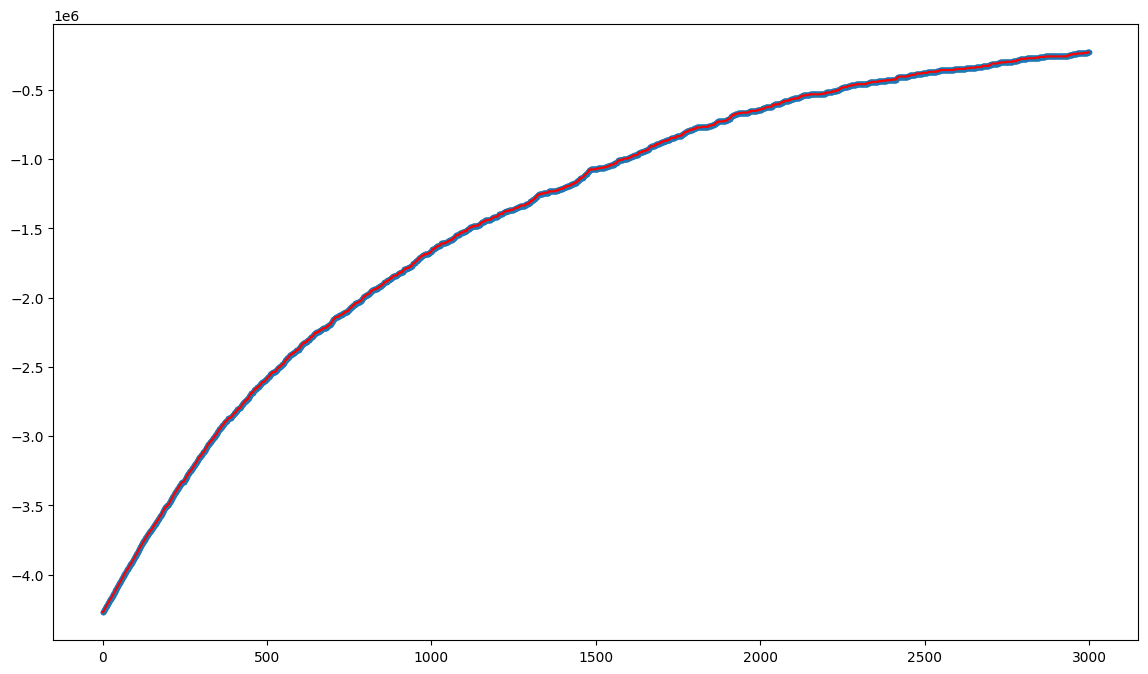

In [633]:
initial_solution = np.full(NUM_SETS, True)

solution, history = set_cover(initial_solution)

# Result
solution_fitness = fitness(solution)
print(f'The solution is{"" if solution_fitness[0] else " not"} valid, the final cost is {-solution_fitness[1]}')

# Graph
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

We can see that the algorithm climbs pretty slowly, in fact we are only on the exploitation of a solution and never on the exploration.

## Multiple random mutation

We can change the tweak function to allow more large steps by performing multiple random mutations on the solution.

In [634]:
def tweak(solution: np.ndarray) -> np.ndarray:
    """tweak function that perform a mutation on n random index according to a probability"""
    mask = np.random.random(NUM_SETS) < 0.01
    new_sol = np.logical_xor(solution, mask)
    return new_sol

Since we do more large steps, we can update our initial solution to be a random point on the fitness landscape. The probability of not having a valid solution at the end exists, but it's very low.

Let's run it again and see what happens.

The solution is valid, the final cost is 817363.3186716035


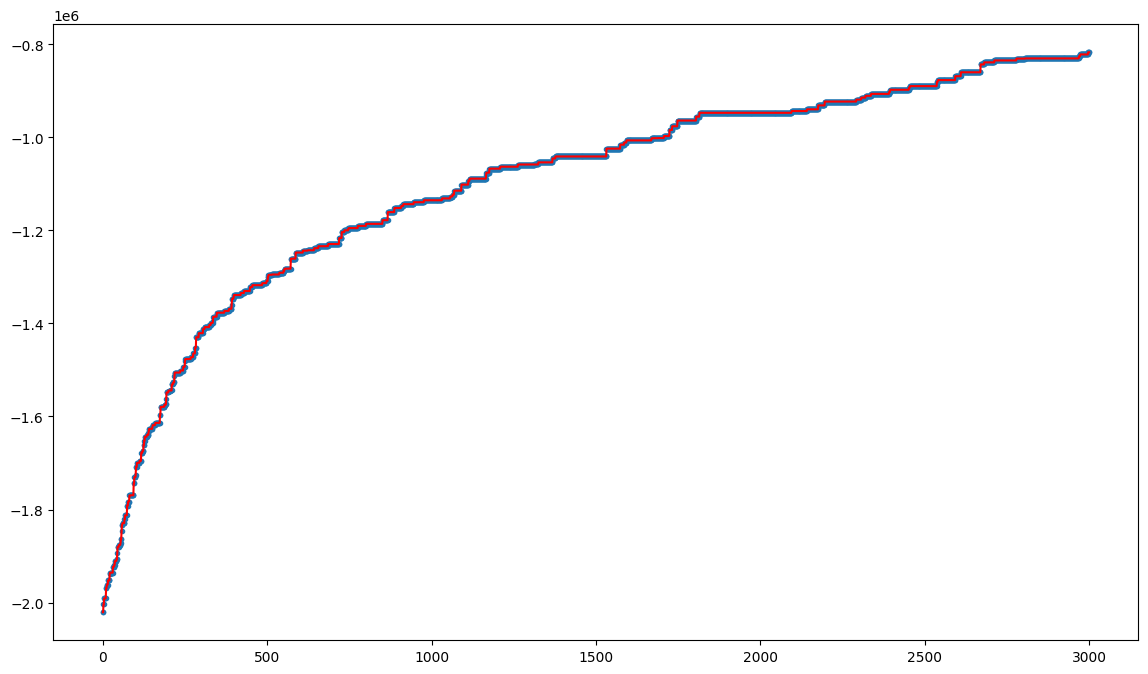

In [635]:
initial_solution = np.random.random(NUM_SETS) < .5

solution, history = set_cover(initial_solution)

# Result
solution_fitness = fitness(solution)
print(f'The solution is{"" if solution_fitness[0] else " not"} valid, the final cost is {-solution_fitness[1]}')


# Graph
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")



The start is faster but we have a hard time performing exploitation of one solution because of our large steps.

## Multiple random mutation with a given strength

To be more efficient, what we can do is simply allowing more large steps at the beginning to improve exploration, and small steps at the end to improve exploitation. Reduce the chance of taking more significant steps over time.

In [636]:
def tweak(solution: np.ndarray, strength: float) -> np.ndarray:
    """tweak function that perform a mutation on n random index according to a probability"""
    mask = np.random.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True 
    new_sol = np.logical_xor(solution, mask)
    return new_sol

Let's define the new set_cover algorithm that decreases the strength over time.

In [637]:
def set_cover(initial_solution: np.ndarray) -> tuple[np.ndarray, list[int]] :
    """Perform a set_cover algorithm on a given initial solution"""
    solution = initial_solution.copy()
    fitness_solution = fitness(solution)
    history = [fitness_solution[1]]
    strength = 0.3
    for _ in range(iterations):
        strength*= 0.994
        test_solution = tweak(solution, strength)
        fitness_test_solution = fitness(test_solution)
        history.append(fitness_solution[1])
        if fitness_test_solution > fitness_solution:
            solution = test_solution
            fitness_solution = fitness_test_solution
    return solution, history

Let's run it again and see what happens.

The solution is valid, the final cost is 152627.12627973035


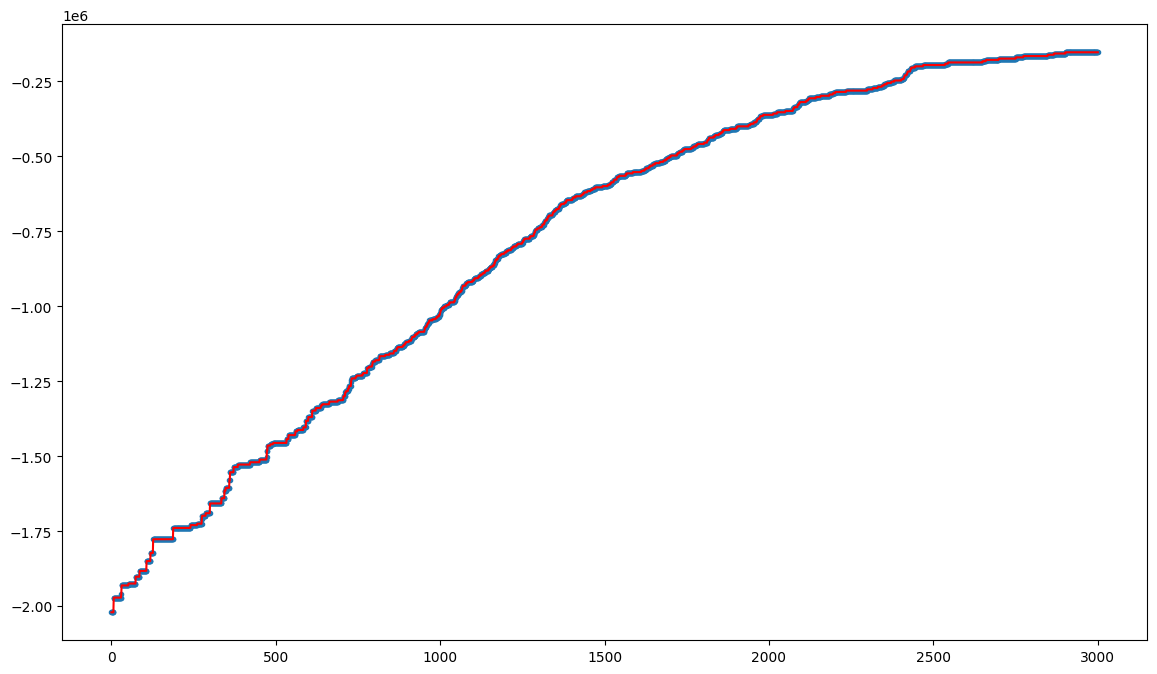

In [638]:
solution, history = set_cover(initial_solution)

# Result
solution_fitness = fitness(solution)
print(f'The solution is{"" if solution_fitness[0] else " not"} valid, the final cost is {-solution_fitness[1]}')

# Graph
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")


As we can see, this is better, we have a fast start (improve exploration), and then we go more slowly (improve exploitation).

The problem here is, no matter what, we decrease the strength. In some cases, this is not the best idea.

## Mutate the strength according to the success

What we can do to have a more reasonable mutation of the strength is to use the 1/5 success rule :
- If we have more than one success over five iterations, improve the strength.
- If we have less than one success over five iterations, decrease the strength.

In [639]:
def set_cover(initial_solution: np.ndarray) -> tuple[np.ndarray, list[int]] :
    """Perform a set_cover algorithm on a given initial solution"""
    solution = initial_solution.copy()
    fitness_solution = fitness(solution)
    history = [fitness_solution[1]]
    strength = 0.3
    succes = 0
    c = 0.98
    for i in range(iterations):
        if i%5:
            if succes > 1:
                strength/c
            elif succes < 1:
                strength*=c
            succes = 0
        test_solution = tweak(solution, strength)
        fitness_test_solution = fitness(test_solution)
        history.append(fitness_solution[1])
        if fitness_test_solution > fitness_solution:
            solution = test_solution
            fitness_solution = fitness_test_solution
            succes += 1
    return solution, history

Let's run it again and see what happens.

The solution is valid, the final cost is 149009.28644932396


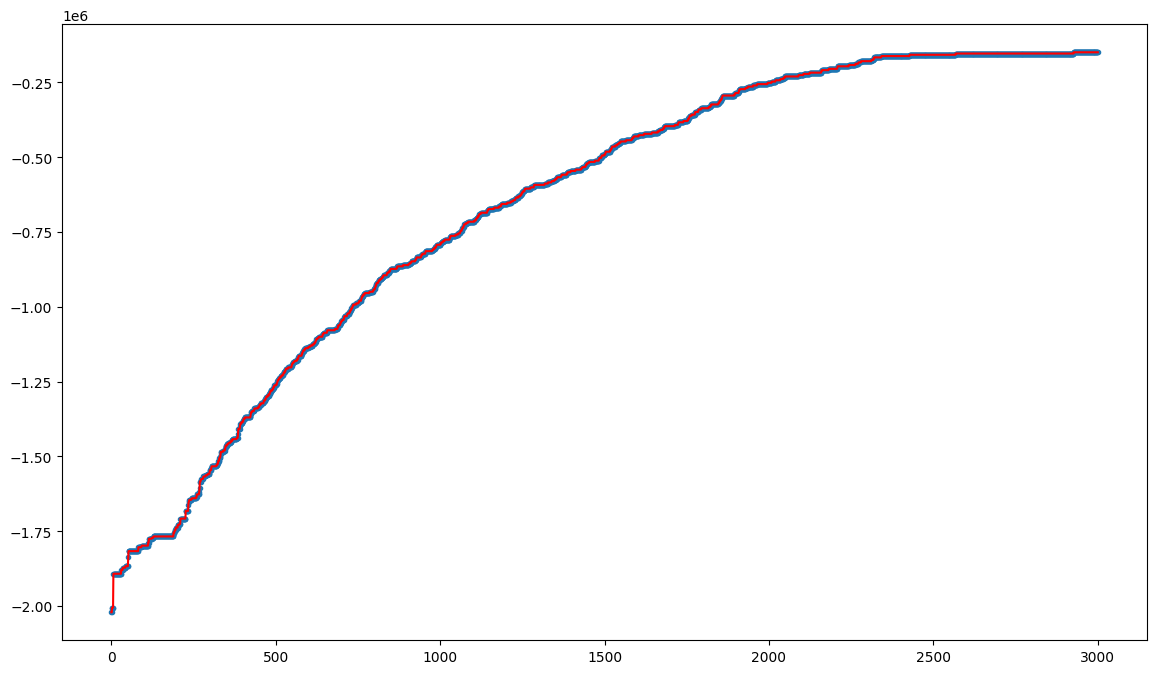

In [640]:
solution, history = set_cover(initial_solution)

# Result
solution_fitness = fitness(solution)
print(f'The solution is{"" if solution_fitness[0] else " not"} valid, the final cost is {-solution_fitness[1]}')

# Graph
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")


This is better, there is always a place for improvement since we will perform large/small steps according to our previous success.

Now the only issue is that our algorithm will depend on the local optimum we are, and we can have bad results if we are in a bad one.

## Compare multiple local optimums

What we can do is performing multiple times the algorithm and select the best solution.

It will increase a lot a time of the algorithm.

A solution could be to let the algorithm do more large steps and perform less iterations to search fast for the local optimum (without having the perfect point for each local optimums).

The solution is valid, the final cost is 127202.33633338637


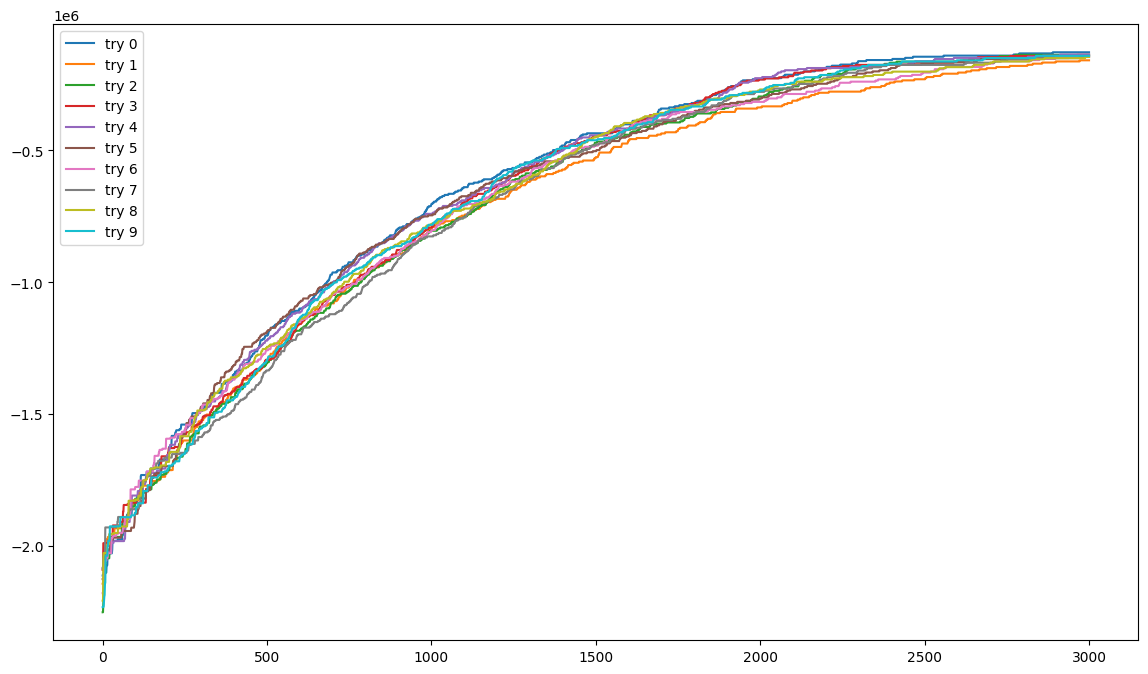

In [643]:
def multiple_set_cover(trials: int):
    """Perform multiple time a set_cover algorithm and return the best one"""
    solution = np.random.random(NUM_SETS) < .5
    plt.figure(figsize=(14, 8))
    for i in range(trials):
        new_solution = np.random.random(NUM_SETS) < .5
        new_solution, history = set_cover(new_solution)
        plt.plot(
            range(len(history)),
            list(accumulate(history, max)),
            label=f"try {i}"
        )
        if (fitness(new_solution) > fitness(solution)):
            solution = new_solution
    solution_fitness = fitness(solution)
    print(f'The solution is{"" if solution_fitness[0] else " not"} valid, the final cost is {-solution_fitness[1]}')
    plt.legend()
    plt.show()
    return

trials = 10
multiple_set_cover(trials)

As we can see, this is the better so far.

We can then define if want to have a better result or if we want a simple result rapidly, by tweaking the number of iterations and trials.

As the problem size growth we want less trials and more iterations. Because when the problem is small, there is no need to perform many iterations to arrive at a local optimum so just compare many local optimums. And when the problem is big, the time to arrive at a local maximum is huge, so it's better to perform less trials but longer.

As you can see in the [set_cover.py](./set_cover.py) file, I choose the constants according to the problem size.